## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

def build_mlp(input_shape, regularization, ratio, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    if regularization == "l1":
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l1(ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1(ratio))(x)
    elif regularization == "l2":
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l2(ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l2(ratio))(x)
    else:
        for i, n_units in enumerate(num_neurons):
            if i == 0:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l1_l2(ratio))(input_layer)
            else:
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l1_l2(ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
# 設定超參數
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
REGULARIZATION = ["l1", "l2", "l1_l2"]
EXP = [1e-2, 1e-4, 1e-8]

In [7]:
results = {}

for regularization in REGULARIZATION:
    for regulizer_ratio in EXP:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print(f"Regularization: {regularization}, Ratio: {regulizer_ratio}")
        model = build_mlp(input_shape=x_train.shape[1:], regularization=regularization, ratio=regulizer_ratio)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["accuracy"]
        valid_acc = model.history.history["val_accuracy"]

        exp_name_tag = "Regularization: %s, Ratio: %s" % (regularization, str(regulizer_ratio))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}


Regularization: l1, Ratio: 0.01
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 512)               1573376   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               131328    
                                                                 
 hidden_layer3 (Dense)       (None, 128)               32896     
                                                                 
 output (Dense)              (None, 10)                1290      
                                                                 
Total params: 1738890 (6.63 MB)
Trainable params: 1738890 (6.63 MB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________

Epoch 1/50



196/196 [==============================] - 4s 20ms/step - loss: 51.2288 - accuracy: 0.1267 - val_loss: 3.9025 - val_accuracy: 0.1000
Epoch 2/50
196/196 [==============================] - 5s 24ms/step - loss: 3.9058 - accuracy: 0.0980 - val_loss: 3.9005 - val_accuracy: 0.1000
Epoch 3/50
196/196 [==============================] - 4s 23ms/step - loss: 3.9058 - accuracy: 0.0991 - val_loss: 3.9029 - val_accuracy: 0.1000
Epoch 4/50
196/196 [==============================] - 4s 22ms/step - loss: 3.9058 - accuracy: 0.0973 - val_loss: 3.9011 - val_accuracy: 0.1000
Epoch 5/50
196/196 [==============================] - 4s 21ms/step - loss: 3.9058 - accuracy: 0.0986 - val_loss: 3.9006 - val_accuracy: 0.1000
Epoch 6/50
196/196 [==============================] - 4s 20ms/step - loss: 3.9057 - accuracy: 0.0977 - val_loss: 3.9005 - val_accuracy: 0.1000
Epoch 7/50
196/196 [==============================] - 4s 20ms/step - loss: 3.9058 - accuracy: 0.0992 - val_loss: 3.9010 - val_accuracy: 0.1000
Epoch 8/5

Epoch 1/50
196/196 [==============================] - 5s 24ms/step - loss: 5.5850 - accuracy: 0.3402 - val_loss: 5.1538 - val_accuracy: 0.3772
Epoch 2/50
196/196 [==============================] - 5s 23ms/step - loss: 4.7639 - accuracy: 0.4269 - val_loss: 4.7053 - val_accuracy: 0.3578
Epoch 3/50
196/196 [==============================] - 5s 23ms/step - loss: 4.1506 - accuracy: 0.4535 - val_loss: 3.9771 - val_accuracy: 0.4170
Epoch 4/50
196/196 [==============================] - 5s 23ms/step - loss: 3.6313 - accuracy: 0.4692 - val_loss: 3.4254 - val_accuracy: 0.4676
Epoch 5/50
196/196 [==============================] - 4s 22ms/step - loss: 3.2007 - accuracy: 0.4814 - val_loss: 3.0475 - val_accuracy: 0.4719
Epoch 6/50
196/196 [==============================] - 4s 22ms/step - loss: 2.8424 - accuracy: 0.4896 - val_loss: 2.7486 - val_accuracy: 0.4704
Epoch 7/50
196/196 [==============================] - 5s 23ms/step - loss: 2.5436 - accuracy: 0.4980 - val_loss: 2.5057 - val_accuracy: 0.4627

Epoch 1/50
196/196 [==============================] - 5s 25ms/step - loss: 1.8237 - accuracy: 0.3503 - val_loss: 1.7203 - val_accuracy: 0.3808
Epoch 2/50
196/196 [==============================] - 4s 23ms/step - loss: 1.5981 - accuracy: 0.4323 - val_loss: 1.6377 - val_accuracy: 0.4232
Epoch 3/50
196/196 [==============================] - 5s 23ms/step - loss: 1.5082 - accuracy: 0.4644 - val_loss: 1.5431 - val_accuracy: 0.4506
Epoch 4/50
196/196 [==============================] - 5s 26ms/step - loss: 1.4475 - accuracy: 0.4843 - val_loss: 1.6033 - val_accuracy: 0.4227
Epoch 5/50
196/196 [==============================] - 5s 24ms/step - loss: 1.4009 - accuracy: 0.5028 - val_loss: 1.4712 - val_accuracy: 0.4791
Epoch 6/50
196/196 [==============================] - 5s 26ms/step - loss: 1.3636 - accuracy: 0.5149 - val_loss: 1.4744 - val_accuracy: 0.4822
Epoch 7/50
196/196 [==============================] - 5s 25ms/step - loss: 1.3204 - accuracy: 0.5305 - val_loss: 1.4085 - val_accuracy: 0.5007

Epoch 1/50
196/196 [==============================] - 6s 27ms/step - loss: 9.6796 - accuracy: 0.3356 - val_loss: 4.9178 - val_accuracy: 0.3767
Epoch 2/50
196/196 [==============================] - 6s 28ms/step - loss: 3.3180 - accuracy: 0.3931 - val_loss: 2.3790 - val_accuracy: 0.4013
Epoch 3/50
196/196 [==============================] - 5s 26ms/step - loss: 2.1090 - accuracy: 0.4060 - val_loss: 1.9049 - val_accuracy: 0.4333
Epoch 4/50
196/196 [==============================] - 5s 25ms/step - loss: 1.8736 - accuracy: 0.4163 - val_loss: 1.8791 - val_accuracy: 0.3946
Epoch 5/50
196/196 [==============================] - 5s 25ms/step - loss: 1.8227 - accuracy: 0.4233 - val_loss: 1.8593 - val_accuracy: 0.4063
Epoch 6/50
196/196 [==============================] - 5s 24ms/step - loss: 1.8124 - accuracy: 0.4243 - val_loss: 1.7805 - val_accuracy: 0.4329
Epoch 7/50
196/196 [==============================] - 5s 24ms/step - loss: 1.7955 - accuracy: 0.4306 - val_loss: 1.8224 - val_accuracy: 0.4145

Epoch 1/50
196/196 [==============================] - 3s 14ms/step - loss: 1.9675 - accuracy: 0.3456 - val_loss: 1.7944 - val_accuracy: 0.4060
Epoch 2/50
196/196 [==============================] - 5s 24ms/step - loss: 1.7370 - accuracy: 0.4337 - val_loss: 1.7598 - val_accuracy: 0.4250
Epoch 3/50
196/196 [==============================] - 4s 22ms/step - loss: 1.6523 - accuracy: 0.4611 - val_loss: 1.6448 - val_accuracy: 0.4656
Epoch 4/50
196/196 [==============================] - 5s 25ms/step - loss: 1.5887 - accuracy: 0.4857 - val_loss: 1.6240 - val_accuracy: 0.4642
Epoch 5/50
196/196 [==============================] - 4s 23ms/step - loss: 1.5378 - accuracy: 0.5035 - val_loss: 1.5967 - val_accuracy: 0.4759
Epoch 6/50
196/196 [==============================] - 2s 10ms/step - loss: 1.4940 - accuracy: 0.5177 - val_loss: 1.5552 - val_accuracy: 0.4942
Epoch 7/50
196/196 [==============================] - 2s 10ms/step - loss: 1.4585 - accuracy: 0.5325 - val_loss: 1.5467 - val_accuracy: 0.4929

Epoch 1/50
196/196 [==============================] - 5s 21ms/step - loss: 1.8226 - accuracy: 0.3468 - val_loss: 1.8270 - val_accuracy: 0.3523
Epoch 2/50
196/196 [==============================] - 4s 20ms/step - loss: 1.5955 - accuracy: 0.4356 - val_loss: 1.5980 - val_accuracy: 0.4291
Epoch 3/50
196/196 [==============================] - 4s 20ms/step - loss: 1.5071 - accuracy: 0.4646 - val_loss: 1.6044 - val_accuracy: 0.4208
Epoch 4/50
196/196 [==============================] - 5s 24ms/step - loss: 1.4520 - accuracy: 0.4842 - val_loss: 1.6442 - val_accuracy: 0.4233
Epoch 5/50
196/196 [==============================] - 5s 26ms/step - loss: 1.4031 - accuracy: 0.5001 - val_loss: 1.4676 - val_accuracy: 0.4780
Epoch 6/50
196/196 [==============================] - 5s 28ms/step - loss: 1.3641 - accuracy: 0.5138 - val_loss: 1.4019 - val_accuracy: 0.5002
Epoch 7/50
196/196 [==============================] - 5s 27ms/step - loss: 1.3239 - accuracy: 0.5293 - val_loss: 1.4505 - val_accuracy: 0.4817

Epoch 1/50
196/196 [==============================] - 3s 15ms/step - loss: 51.2218 - accuracy: 0.1214 - val_loss: 3.9019 - val_accuracy: 0.1000
Epoch 2/50
196/196 [==============================] - 5s 24ms/step - loss: 3.9010 - accuracy: 0.1000 - val_loss: 3.8948 - val_accuracy: 0.1000
Epoch 3/50
196/196 [==============================] - 5s 25ms/step - loss: 3.8991 - accuracy: 0.0996 - val_loss: 3.8957 - val_accuracy: 0.1000
Epoch 4/50
196/196 [==============================] - 5s 24ms/step - loss: 3.8972 - accuracy: 0.0987 - val_loss: 3.8974 - val_accuracy: 0.1000
Epoch 5/50
196/196 [==============================] - 5s 25ms/step - loss: 3.8949 - accuracy: 0.0978 - val_loss: 3.8885 - val_accuracy: 0.1000
Epoch 6/50
196/196 [==============================] - 2s 12ms/step - loss: 3.8925 - accuracy: 0.0985 - val_loss: 3.8892 - val_accuracy: 0.1000
Epoch 7/50
196/196 [==============================] - 2s 11ms/step - loss: 3.8905 - accuracy: 0.0981 - val_loss: 3.8878 - val_accuracy: 0.100

Epoch 1/50
196/196 [==============================] - 3s 13ms/step - loss: 11.7470 - accuracy: 0.3351 - val_loss: 5.4954 - val_accuracy: 0.3753
Epoch 2/50
196/196 [==============================] - 2s 12ms/step - loss: 3.5031 - accuracy: 0.3829 - val_loss: 2.4915 - val_accuracy: 0.3332
Epoch 3/50
196/196 [==============================] - 2s 12ms/step - loss: 2.1392 - accuracy: 0.3791 - val_loss: 2.0068 - val_accuracy: 0.3798
Epoch 4/50
196/196 [==============================] - 2s 12ms/step - loss: 1.9756 - accuracy: 0.3811 - val_loss: 1.9156 - val_accuracy: 0.3983
Epoch 5/50
196/196 [==============================] - 2s 12ms/step - loss: 1.9229 - accuracy: 0.3917 - val_loss: 1.8864 - val_accuracy: 0.4034
Epoch 6/50
196/196 [==============================] - 2s 12ms/step - loss: 1.9023 - accuracy: 0.3968 - val_loss: 1.8752 - val_accuracy: 0.3931
Epoch 7/50
196/196 [==============================] - 2s 12ms/step - loss: 1.8923 - accuracy: 0.4016 - val_loss: 1.8901 - val_accuracy: 0.395

Epoch 1/50
196/196 [==============================] - 4s 13ms/step - loss: 9.6984 - accuracy: 0.3322 - val_loss: 4.9344 - val_accuracy: 0.3676
Epoch 2/50
196/196 [==============================] - 2s 12ms/step - loss: 3.3201 - accuracy: 0.3956 - val_loss: 2.3781 - val_accuracy: 0.3989
Epoch 3/50
196/196 [==============================] - 2s 12ms/step - loss: 2.1100 - accuracy: 0.4057 - val_loss: 1.9432 - val_accuracy: 0.4013
Epoch 4/50
196/196 [==============================] - 2s 12ms/step - loss: 1.8838 - accuracy: 0.4110 - val_loss: 1.8812 - val_accuracy: 0.4034
Epoch 5/50
196/196 [==============================] - 2s 12ms/step - loss: 1.8422 - accuracy: 0.4164 - val_loss: 1.9400 - val_accuracy: 0.3662
Epoch 6/50
196/196 [==============================] - 2s 12ms/step - loss: 1.8261 - accuracy: 0.4215 - val_loss: 1.8229 - val_accuracy: 0.4087
Epoch 7/50
196/196 [==============================] - 2s 12ms/step - loss: 1.8010 - accuracy: 0.4269 - val_loss: 1.8478 - val_accuracy: 0.3911

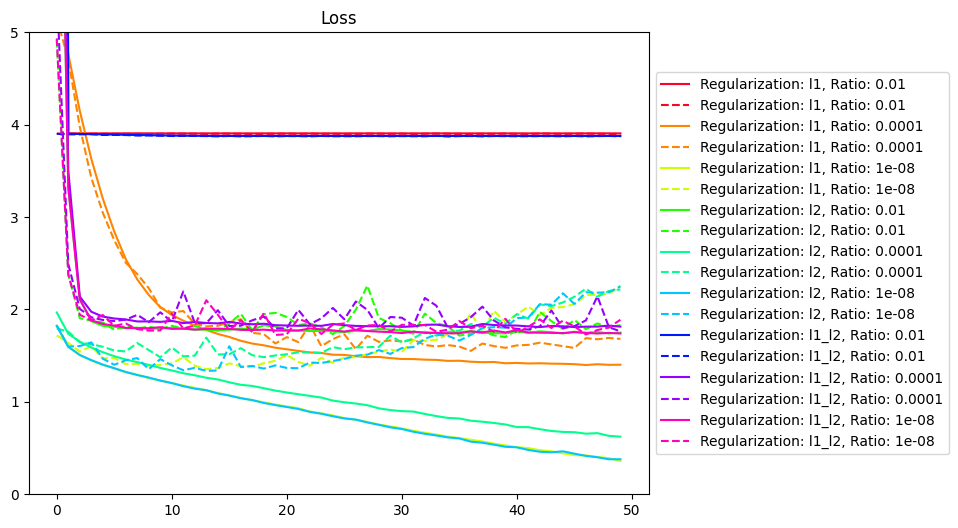

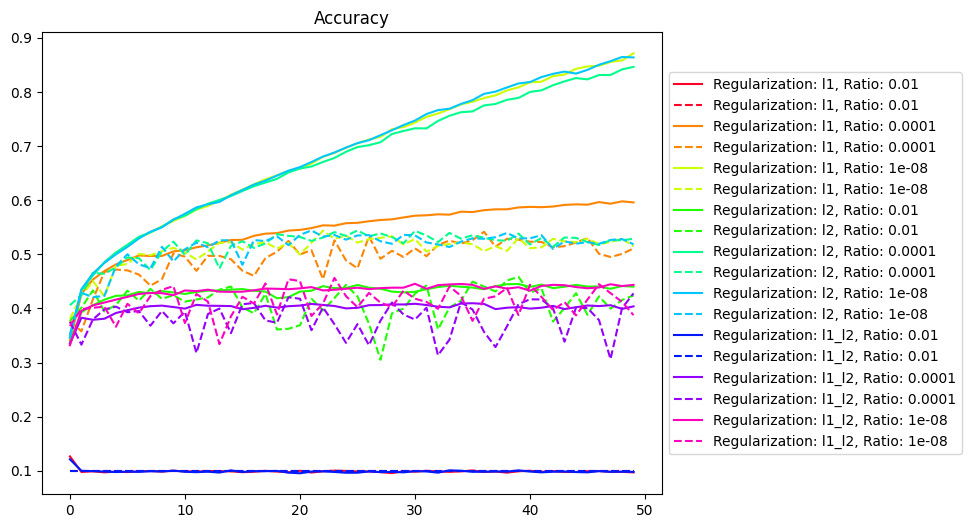

In [8]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = 9

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()